# Part 5  - Clément Royer (Proximal gradient and LASSO)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
from numpy.linalg import norm
%matplotlib inline

#### Pre-processing the data

In [40]:
data = pd.read_csv('./data/winequality-red.csv', sep=',')
data = data.drop_duplicates()

In [41]:
# copy the data
data_scaled = data.copy()
mean_data = data_scaled.mean()
std_data =  data_scaled.std()

# apply normalization techniques
for column in data_scaled.columns:
    if column!='MEDV':
        data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]
    else : data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]

# view normalized data   
data_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524238,0.931657,-1.392745,-0.460987,-0.245532,-0.468381,-0.383908,0.583788,1.291397,-0.578348,-0.954023,-0.756762
1,-0.293955,1.915095,-1.392745,0.056644,0.200020,0.871682,0.603851,0.048719,-0.708135,0.124776,-0.584360,-0.756762
2,-0.293955,1.259470,-1.188180,-0.165198,0.078506,-0.085506,0.214734,0.155733,-0.321129,-0.051005,-0.584360,-0.756762
3,1.663455,-1.363032,1.471170,-0.460987,-0.265785,0.105932,0.394326,0.690802,-0.966139,-0.461161,-0.584360,0.457452
5,-0.524238,0.713115,-1.392745,-0.534935,-0.265785,-0.276944,-0.204316,0.583788,1.291397,-0.578348,-0.954023,-0.756762


In [42]:
df_label = data_scaled['quality']
df_features = data_scaled.drop(columns=['quality']) 

X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.33, random_state=42, shuffle = True)

A_test = X_test.to_numpy() #training matrix
Y_test = y_test.to_numpy() #label matrix
A_train = X_train.to_numpy() #training matrix
Y_train = y_train.to_numpy() #label matrix
p = X_train.shape[1] #number of feature
n = X_train.shape[0] #nb of data point
#x0 = np.random.rand(p).T #random initial point 
x0 = np.zeros((p))


#### Gradient function

In [17]:
def gradient_descent(x0, A, y, iterations = 50, learning_rate = 0.01, stopping_threshold = 1e-6):

    # Initializing learning rate and iterations
    loss = [] #to return 
    past_x = [] #to return
    previous_loss = None
    vector=x0 #starting point
    n = X_train.shape[0] #nb of data point
    # Estimation of optimal parameters
    for _ in range(iterations):
        # Calculating a new prediction
        prediction = A.dot(vector)
        #mean square error
        error = y - prediction 
        mse = (1/(2*n))*(np.dot(error.T,error))

        loss.append(mse)
        # If the change in cost is less than or equal to stopping_threshold we stop the gradient 
        #print(mse)
        if previous_loss and abs(previous_loss-mse)<=stopping_threshold:
             break

        #calcultating gradient
        grad = (-1/n) * A.transpose().dot(error)

        #gradient descent step
        vector = vector - (learning_rate * grad)

        previous_loss = mse
        # Printing the mse for each iteration
        #print(f"Iteration {i+1}: Cost {mse}")

    return vector, loss

In [43]:
def gradient_descent_l2(x0, A, y, Lambda, iterations = 50, learning_rate = 0.01, stopping_threshold = 1e-6):

    # Initializing learning rate and iterations
    loss = [] #to return 
    past_x = [] #to return
    previous_loss = None
    vector=x0.copy #starting point
    n = X_train.shape[0] #nb of data point
    # Estimation of optimal parameters
    for _ in range(iterations):
        # Calculating a new prediction
        prediction = A.dot(vector)
        #mean square error
        error = y - prediction
        mse = (1/(2*n))*(np.dot(error.T,error))
        mse_ridge = mse + (Lambda/2 * norm(vector,2)**2)
        loss.append(mse_ridge)
        #calcultating gradient
        grad = (-1/n) * A.transpose().dot(error) + Lambda*norm(vector)

        #gradient descent step
        vector = vector - (learning_rate * grad)

    return vector, loss

### Question 1

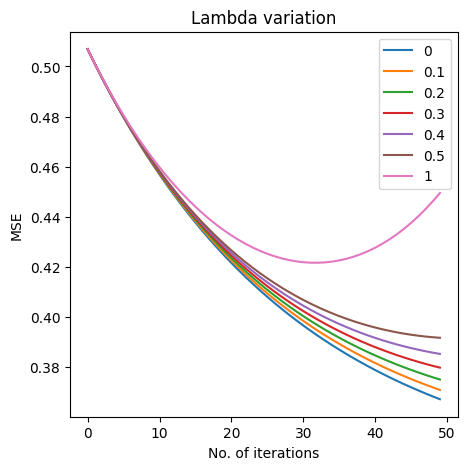

In [6]:
Lambda_mult = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

plt.figure(figsize=(5, 5))
for Lambda in Lambda_mult:
    x0 = np.zeros((p))
    final_x , loss = gradient_descent_l2(x0, A_train , Y_train, Lambda)
    plt.plot(loss, label=str(Lambda))
#final_x , loss = gradient_descent(x0, A_train , Y_train)
#plt.plot(loss, label='gradient_descent')
plt.title('Lambda variation')
plt.xlabel('No. of iterations')
plt.ylabel('MSE')
plt.legend()
plt.show()

For small value of regularization parameter: 
- The solution of the unregularized problem is better performing in terms of convergence than the reguralized problem. 

For a large value of regularization parameter: 
- The reguralized problem is diverging, so the unreguralitzed problem is definitely the best. 

### Question 2

In [45]:
def gradient_descent_l1(x0, A, y, Lambda, iterations = 50, learning_rate = 0.01, stopping_threshold = 1e-6):

    # Initializing learning rate and iterations
    loss = [] #to return 
    vector=x0.copy() #starting point
    n,p = X_train.shape #nb of data point
    data_fitting = []
    # Estimation of optimal parameters
    for _ in range(iterations):
        # Calculating a new prediction
        prediction = A.dot(vector)
        #mean square error
        error = y - prediction 
        mse = (1/(2*n))*(np.dot(error.T,error))
        data_fitting.append(mse)
        #adding the l1 term
        mse_ridge = mse + (Lambda * norm(vector,1))
        loss.append(mse_ridge)
        #calcultating gradient
        grad =(-(A.transpose().dot(error)))/n

        g = vector - (learning_rate * grad)
        for i in range(p):
            if (g[i] < - Lambda*learning_rate):
                #gradient descent step
                vector[i] = vector[i] - (learning_rate * grad[i]) + learning_rate* Lambda
            elif (g[i] > Lambda*learning_rate):
                #gradient descent step
                vector[i] = vector[i] - (learning_rate * grad[i]) - learning_rate* Lambda
            else :
                vector[i] = 0 #help determine the sparse solution

    return vector, loss, data_fitting

Nonzero coefficients with lbda=0: 11
Nonzero coefficients with lbda=0.001098901098901099: 11
Nonzero coefficients with lbda=0.006035579235710375: 11
Nonzero coefficients with lbda=0.010648924267509345: 11
Nonzero coefficients with lbda=0.033149677206589796: 9
Nonzero coefficients with lbda=0.10319362513018594: 7


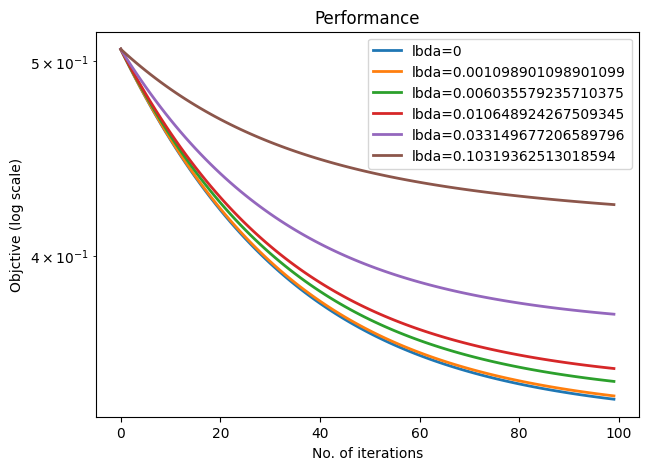

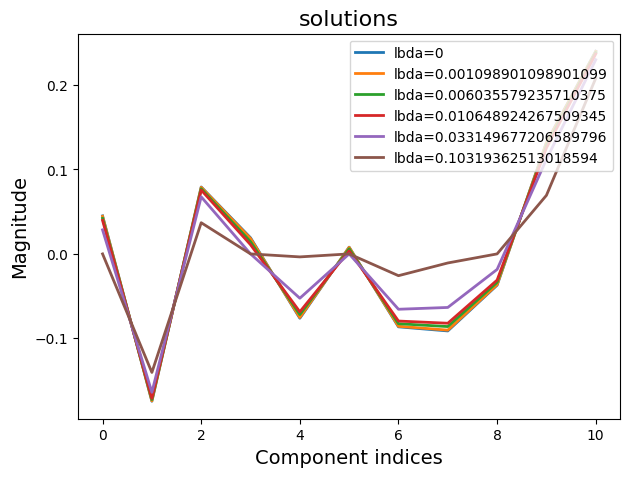

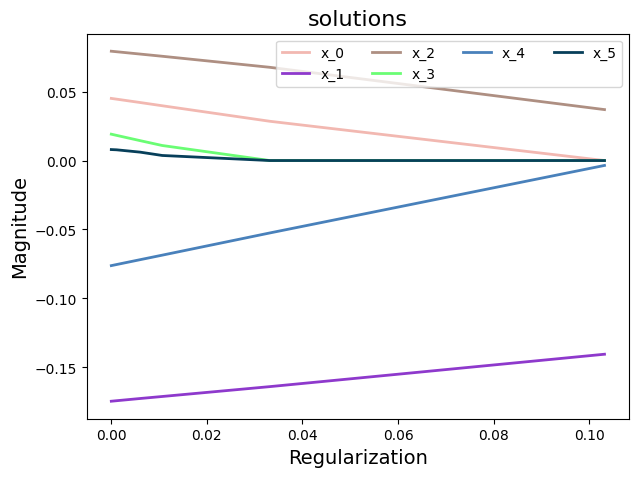

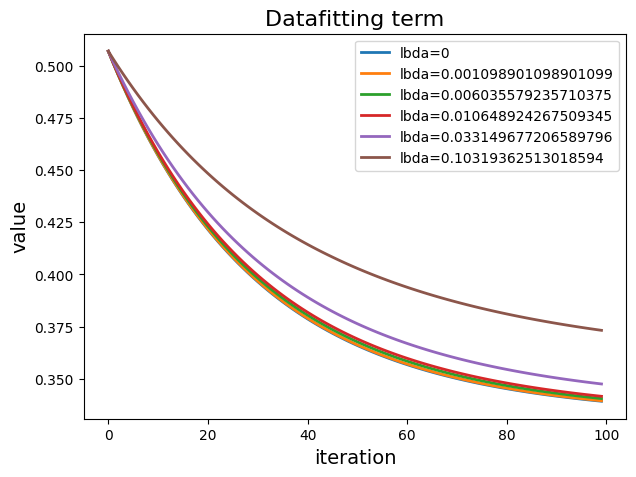

In [64]:
n,p = X_train.shape

puiss_Lambda_mult = [0,1/n,1/(n**(3/4)),1/(n**(2/3)),1/(n**(1/2)),1/(n**(1/3))]
nlbda = len(puiss_Lambda_mult)
n,p = X_train.shape
Xsol = np.zeros((p,nlbda))
fitting_term = np.zeros((100,nlbda))
plt.figure(figsize=(7, 5))
for i in range(nlbda):
    x0 = np.zeros(p)
    Xsol[:,i] , loss, fitting_term[:,i]  = gradient_descent_l1(x0, A_train , Y_train ,puiss_Lambda_mult[i],learning_rate=0.01, iterations=100)
    print("Nonzero coefficients with lbda="+str(puiss_Lambda_mult[i])+": "+str(np.count_nonzero(Xsol[:,i])))
    plt.semilogy(loss, label='lbda='+str(puiss_Lambda_mult[i]),lw=2)
#vector , loss = gradient_descent(x0, A_train , Y_train, iterations=100)
#plt.plot(loss, label='gradient_descent')
plt.title('Performance')
plt.xlabel('No. of iterations')
plt.ylabel('Objctive (log scale)')
plt.legend()

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(puiss_Lambda_mult[i]), lw=2)
plt.title("solutions", fontsize=16)
plt.xlabel("Component indices", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(puiss_Lambda_mult,Xsol[i,:],label="x_"+str(i),c=np.random.rand(3,), lw=2)
plt.title("solutions", fontsize=16)
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(fitting_term[:,i] ,label="lbda="+str(puiss_Lambda_mult[i]), lw=2)
plt.title("Datafitting term", fontsize=16)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.legend(loc=1)


I plotted wht we need to answer about sparsity, convergence and data fitting term behavior.